## Community Detection

In this notebook we will walk through a number of methods for community detection using a simple example dataset.




In [2]:
import numpy,pandas
import networkx as nx
import matplotlib.pyplot as plt
import sys
import operator 
import itertools

#sys.path.append('../utils')
from brainnetworks.utils import algorithm_u
from brainnetworks.utils import module_degree_zscore,participation_coefficient

%matplotlib inline

### Example graph

First let's create a simple graph that has two communities, each of which is fully connected, with one node from each community connected to a node in the other community.

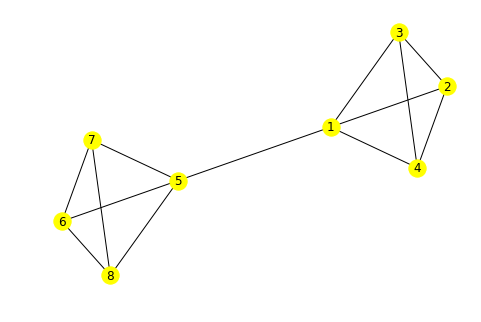

In [3]:
G = nx.Graph()
# nodes 1-4 are members of one community, and 5-8 are members of another, with 1 and 5 connected as well
edges=[(1,2),(1,3),(1,4),(1,5),(5,6),(5,7),(5,8),(6,7),(6,8),(7,8),(2,3),(2,4),(3,4)]
G.add_edges_from(edges)

nx.draw_spring(G,with_labels=True,node_color='yellow')

### Girvan-Newman method

The Girvan-Newman method is a *divisive* clustering method, meaning that it starts with the full graph and tries to find the best way to divide it into some number of clusters by removing particular edges.

The algorithm was defined by [Girvan & Newman (2002)](http://www.pnas.org/content/99/12/7821) as follows:

1. Calculate the betweenness for all edges in the network.
2. Remove the edge with the highest betweenness.
3. Recalculate betweennesses for all edges affected by the
removal.
4. Repeat from step 2 until no edges remain.

Let's implement this for the example dataset, finding two clusters.

In [4]:
n_clusters=len([i for i in nx.connected_components(G)])
G_tmp=G.copy()  # make a copy of the graph to work with
while n_clusters==1:
    # step 1: compute edge betweenness
    eb=nx.edge_betweenness(G_tmp)
    
    # step 2: remove the edge with highest betweeness
    # find the edge with the largest value of edge betweenness
    ebmax = max(eb.items(), key=operator.itemgetter(1))[0]
    # remove it from the graph
    G_tmp.remove_edges_from([ebmax])
    print('removing edge:',ebmax)
    
    # compute the number of connected components to see if we have
    # induced new clusters, and continue looping if not
    n_clusters=len([i for i in nx.connected_components(G_tmp)])
    
print('found two clusters:')
print([list(i.nodes) for i in nx.connected_component_subgraphs(G_tmp)])

removing edge: (1, 5)
found two clusters:
[[1, 2, 3, 4], [5, 6, 7, 8]]


### Modularity

One of the most commonly used set of methods for community detection rely upon the concept of *modularity*.  Here we will walk through the computation of modularity for a simple graph.

Here is one expression for modularity, from [Fortunato, 2010](https://arxiv.org/pdf/0906.0612.pdf):

$$
Q = \frac{1}{2m}\sum_{ij}(A_{ij} - P_{ij})\delta(C_i,C_j)
$$

where $m$ is the total number of edges in the graph, $A$ is the adjacency matrix, and $P_{ij}$ is the expected number of edges between i and j according to the apporpriate null model, and $\delta$ is a matrix that denotes whether vertices i and j are within the same community:

$$
\delta(C_i,C_j) = \left\{
                \begin{array}{ll}
                  1\ if\ C_i=C_j\\
                  0\ if\ C_i \neq C_j\\
                \end{array}\right.
$$

To compute modularity for our example graph (which looks to be fairly modular), we first need the adjacency matrix.

In [5]:
A = nx.to_numpy_array(G)
print(A)

[[0. 1. 1. 1. 1. 0. 0. 0.]
 [1. 0. 1. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1. 0. 1.]
 [0. 0. 0. 0. 1. 1. 1. 0.]]


Next we need to generate the $\delta$ matrix denoting whether each pair of vertices is a member of the same community.

In [6]:
partition = [1,1,1,1,2,2,2,2]
delta = numpy.zeros((len(partition),len(partition)))
for i in range(len(partition)):
    for j in range(len(partition)):
        delta[i,j]=int(partition[i]==partition[j])
        
print(delta)

[[1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1.]]


The final thing we need is the expected edge frequency from the null model.  In general we want the null model to match the actual graph as closely as possible, except for the clustering. It is common to use a null model in which the degree sequence (i.e. the values of degrees for all nodes) is identical to the real graph; this is a more stringent null model than simply equating the degree distribution.  This null model can be written as (Fortunato, 2010):

$$
Q = \frac{1}{2m}\sum_{ij}\bigg(A_{ij} - \frac{k_i k_j}{2m}\bigg)\delta(C_i,C_j)
$$

where $k_i$ is the degree of vertex $i$.  Note that this null model will not necessarily give an identical degree sequence on any particular realization, but should be the same on average.

In [7]:
m = len(G.edges)
k = [G.degree[i] for i in G.nodes] # degree values
Q=0
for i in range(len(k)):
    for j in range(len(k)):
        Q += (A[i,j] - (k[i]*k[j])/(2*m))*delta[i,j]
Q = Q/(2*m)

print(Q)

0.42307692307692296


We can compare our answer to the one given by the built-in modularity function in NetworkX:

In [8]:
assert Q == nx.algorithms.community.quality.modularity(G,
                                            [{1,2,3,4},{5,6,7,8}])

Now let's examine how modularity varies with the partition.  In this case, we can fairly easily compute all 128 possible partitions of the 8 nodes and compute modularity for each.  In principle we should see that the modularity value is highest for the true partition.

In [9]:
Qvals=numpy.zeros(128)
partitions=[]

# loop through all possible partitions of edges into two communities:
for i,p in enumerate(algorithm_u([1,2,3,4,5,6,7,8],2)):
    Qvals[i] = nx.algorithms.community.quality.modularity(G,p)
    partitions.append(p)


maximum Q: 0.42307692307692296
best partition: [[1, 2, 3, 4], [5, 6, 7, 8]]


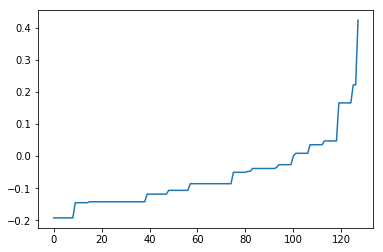

In [10]:
plt.plot(numpy.sort(Qvals))
print('maximum Q:',numpy.max(Qvals))
print('best partition:',partitions[numpy.argsort(Qvals)[-1:][0]])

### Modularity optimization

In general, it's not possible to perform exhaustive computation of modularity for all possible partitions (since the number of possible partitions grows exponentially with the size of the graph), so a number of researchers have developed approximate methods that perform well in finding the partition with the maximum modularity value.

#### Greedy optimization

One approach (proposed initially by [Newman, 2004](https://pdfs.semanticscholar.org/29d4/dfae2807a67a2c66c720b4985cb599c4e245.pdf)) is to perform an *agglomerative* clustering using a ["greedy" algorithm ](https://en.wikipedia.org/wiki/Greedy_algorithm)- that is, an algorithm that makes the best possible choice at each point in the process, akin to climbing a hill by going the steepest upward direction at every point.

In Newman's greedy method, we start with each vertex in its own partition. We then find which combination of partitions would increase modularity the most, and combine those into one.

The implementation here would be far too inefficient to use with real data, but should help make clear how the algorithm works.

In [12]:
# create a function to compute modularity more easily
def modularity(G,partition):
    A = nx.to_numpy_array(G)
    m = len(G.edges)
    delta = numpy.zeros((len(partition),len(partition)))
    for i in range(len(partition)):
        for j in range(len(partition)):
            delta[i,j]=int(partition[i]==partition[j])
   
    k = [G.degree[i] for i in G.nodes] # degree values
    Q=0
    for i in range(len(k)):
        for j in range(len(k)):
            Q += (A[i,j] - (k[i]*k[j])/(2*m))*delta[i,j]
    Q = Q/(2*m)
    return(Q)

Qvals=[-numpy.inf]
notbest=True
partition=numpy.array([1,2,3,4,5,6,7,8])  # initially assign all to the same

while notbest:
    unique_partitions=numpy.unique(partition)
    print('unique partitions:',unique_partitions)
    # loop through all combinations of unique partitions
    modvals={}
    for i in range(len(unique_partitions)):
        for j in range(i+1,len(unique_partitions)):
            if i==j:
                continue
            tmp_part=numpy.array(partition)
            tmp_part[tmp_part==unique_partitions[i]]=unique_partitions[j]
            
            modvals[(unique_partitions[i],unique_partitions[j])]=modularity(G,tmp_part)
    modmax = max(modvals.items(), key=operator.itemgetter(1))[0]
    
    # this method assumes that Q increases monotonically to its maximum
    if modvals[modmax]<numpy.max(numpy.array(Qvals)):
        print('breaking: found best Q value!')
        print(partition)
        notbest=False
    else:
        print('collapsing:',modmax,modvals[modmax])
        partition[partition==modmax[0]]=modmax[1]
        print('new partition:',partition)
        print('')
        Qvals.append(modvals[modmax])


unique partitions: [1 2 3 4 5 6 7 8]
collapsing: (2, 3) -0.07692307692307693
new partition: [1 3 3 4 5 6 7 8]

unique partitions: [1 3 4 5 6 7 8]
collapsing: (3, 4) 0.02366863905325443
new partition: [1 4 4 4 5 6 7 8]

unique partitions: [1 4 5 6 7 8]
collapsing: (1, 4) 0.14792899408284027
new partition: [4 4 4 4 5 6 7 8]

unique partitions: [4 5 6 7 8]
collapsing: (6, 7) 0.19822485207100599
new partition: [4 4 4 4 5 7 7 8]

unique partitions: [4 5 7 8]
collapsing: (7, 8) 0.2988165680473374
new partition: [4 4 4 4 5 8 8 8]

unique partitions: [4 5 8]
collapsing: (5, 8) 0.42307692307692296
new partition: [4 4 4 4 8 8 8 8]

unique partitions: [4 8]
breaking: found best Q value!
[4 4 4 4 8 8 8 8]


### Spectral clustering

Another common method for community detection is spectral clustering, which uses the eigenvectors of matrices that describe the graph.  While we could work with the adjacency matrix, it is more common to use the [Laplacian matrix](https://samidavies.wordpress.com/2016/09/20/whats-up-with-the-graph-laplacian/), which you can think of as describing the flow of some quantity away from any particular node in the graph.

The Laplacian L is defined as:

$$
L = D - A
$$ 

where $A$ is the adjacency matrix, and $D$ is a diagonal matrix where each entry is the degree of that particular node. Here it is for our example graph:

In [11]:
D = numpy.zeros(A.shape)
D[numpy.diag_indices_from(D)]=k
L = D - A
print(L)

[[ 4. -1. -1. -1. -1.  0.  0.  0.]
 [-1.  3. -1. -1.  0.  0.  0.  0.]
 [-1. -1.  3. -1.  0.  0.  0.  0.]
 [-1. -1. -1.  3.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  4. -1. -1. -1.]
 [ 0.  0.  0.  0. -1.  3. -1. -1.]
 [ 0.  0.  0.  0. -1. -1.  3. -1.]
 [ 0.  0.  0.  0. -1. -1. -1.  3.]]


In general, it's more useful to work with the normalized Laplacian, which normalizes by degree. We can compute this easily using linear algebra:

$$
Ln = D^{-\frac{1}{2}}LD^{-\frac{1}{2}}
$$

In [12]:
Ln = numpy.linalg.inv(numpy.sqrt(D)).dot(L).dot(numpy.linalg.inv(numpy.sqrt(D)))
print(Ln)

[[ 1.         -0.28867513 -0.28867513 -0.28867513 -0.25        0.
   0.          0.        ]
 [-0.28867513  1.         -0.33333333 -0.33333333  0.          0.
   0.          0.        ]
 [-0.28867513 -0.33333333  1.         -0.33333333  0.          0.
   0.          0.        ]
 [-0.28867513 -0.33333333 -0.33333333  1.          0.          0.
   0.          0.        ]
 [-0.25        0.          0.          0.          1.         -0.28867513
  -0.28867513 -0.28867513]
 [ 0.          0.          0.          0.         -0.28867513  1.
  -0.33333333 -0.33333333]
 [ 0.          0.          0.          0.         -0.28867513 -0.33333333
   1.         -0.33333333]
 [ 0.          0.          0.          0.         -0.28867513 -0.33333333
  -0.33333333  1.        ]]


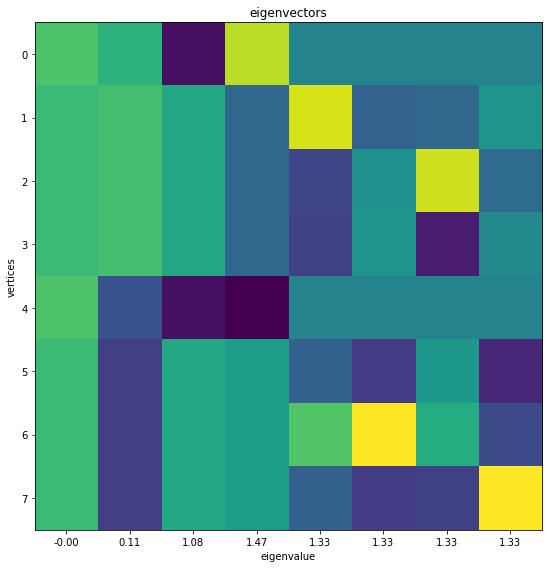

In [13]:
eig = numpy.linalg.eig(Ln)
def plot_eig(eig):
    plt.figure(figsize=(8,8))
    plt.imshow(eig[1])       # Get locations and labels
    _=plt.xticks([i for i in range(len(eig[0]))], ['%0.2f'%i for i in eig[0]])
    plt.xlabel('eigenvalue')
    plt.ylabel("vertices")
    plt.title('eigenvectors')
    plt.tight_layout()
    
plot_eig(eig)

Note that there is a single zero eigenvalue, which represents the fact that there is a single graph component.  Let's see what would happen if we were to add another component:

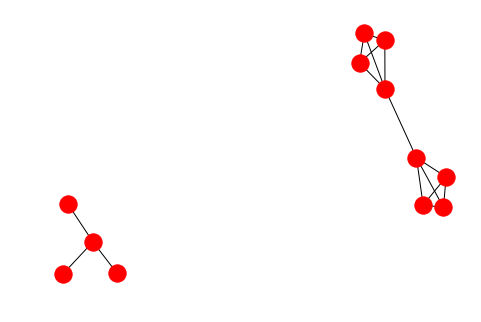

In [14]:
G_bigger = G.copy()
G_bigger.add_edges_from([(9,10),(10,11),(10,12)])
nx.draw_spring(G_bigger)

Now let's get the Laplacian matrix (this time using the built-in NetworkX function) and compute its eigenvalues.

In [15]:
Ln_bigger = nx.normalized_laplacian_matrix(G_bigger).todense()
eig_bigger=numpy.linalg.eig(Ln_bigger)
eig_bigger[0]

array([-5.55111512e-17,  1.13382475e-01,  1.08333333e+00,  1.46995086e+00,
        1.33333333e+00,  1.33333333e+00,  1.33333333e+00,  1.33333333e+00,
        2.00000000e+00,  1.00000000e+00, -1.00275610e-16,  1.00000000e+00])

Here you can see that there are two zero-valued eigenvalues, reflecting the fact that there are two components.

Now look back at the second column in the eigenvector matrix above, corresponding to the second largest eigenvalue.  Let's draw the graph and color the nodes according to the values of this second smallest eigenvalue:

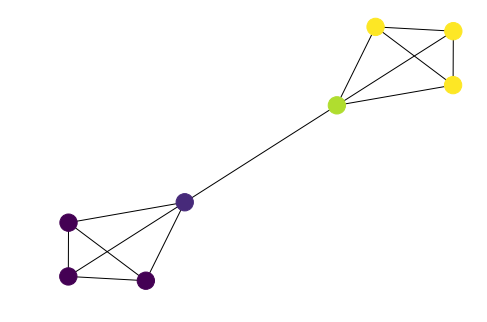

In [16]:
nx.draw_spring(G,node_color=eig[1][:,1],cmap='viridis')

What this shows is that the eigenvector corresponding to the smallest nonzero eigenvalue of the Laplacian matrix divides the graph by its major communities.

Spectral clustering methods take this approach further by treating each vertex in a metric space defined by the eigenvectors, and then using these to perform various clustering operations (e.g., k-means clustering).

### Infomap

The [infomap algorithm](http://www.mapequation.org/code.html) uses a flow-based model along with concepts from information theory to identify communities in the data.  It is based on the idea of a random walk across the network; the fundamental concept is that one can describe a random walk in terms of traversal across communities rather than individual nodes, and an accurate community partition should lead to a compact description of the network.

Let's first simulate a random walk across our example network.

In [17]:
import random
# length of random walk
walkLength = 1000
n=1 # start node

edges_visited = []

for k in range(walkLength):
    e=[i[1] for i in list(G.edges(n))]
    random.shuffle(e)
    edges_visited.append((n,e[0]))
    n=e[0]    



Infomap uses a measure of the relative proportion of within-community versus between-community walks (though it does this using an information theoretic framework).  We can get a simple idea of how this works by simply looking at how often the random walker switches between communities; the best partition should be the one that results in the smallest number of steps between communities.  Let's create a function that can take a random walk and a community partition and tell us the proportion of within-community steps.  We can then apply this to all possible partitions of our example graph, in order to see if the true partition indeed results in the greatest proportion of within-community steps.

In [18]:
def mean_walktype(edges,partition_list):
    """
    compute the proportion of within-community steps in a random walk
    edges is a list of tuples referring to edges in a random walk
    partition_list is a list of lists, as returned by algorithm_u
    """
    # turn partition_list into a partition index
    partition=numpy.zeros(len(list(itertools.chain.from_iterable(partition_list))))
    for i in partition_list[1]:
        partition[i-1]=1
    # create the delta function for the partition
    delta = numpy.zeros((len(partition),len(partition)))
    for i in range(len(partition)):
        for j in range(len(partition)):
            delta[i,j]=int(partition[i]==partition[j])
    
    # create the list of walk types using the delta array
    walktype=[] # 1 for within, 0 for between
    for i in edges:
        walktype.append(delta[i[0]-1,i[1]-1])

    return(numpy.mean(walktype))
    
meanvals=numpy.zeros(128)
partitions=[]
# loop through all possible partitions into two communities:
for i,p in enumerate(algorithm_u([1,2,3,4,5,6,7,8],2)):

    meanvals[i] = mean_walktype(edges_visited,p)
    partitions.append(p)


Confirm that the true partition has the maximum probability of within-community steps

In [19]:
partitions[numpy.argmax(meanvals)]

[[1, 2, 3, 4], [5, 6, 7, 8]]

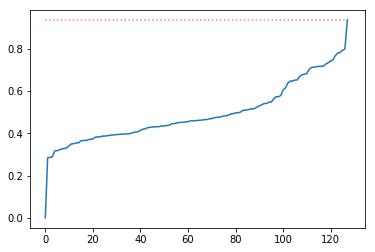

In [20]:
mv=numpy.sort(meanvals)

plt.plot(mv)
# put a line for the value of the true partition
true_p=mean_walktype(edges_visited,[{1,2,3,4},{5,6,7,8}])
plt.plot([0,len(meanvals)],[true_p,true_p],'r',alpha=0.5,linestyle='dotted')

### Network hubs

We know that in any group there are some individuals who are better connected than others, and this was evident from the long-tailed degree distrbution in the Facebook data.  In network science, such high-degree nodes are often referred to as "hubs".  Given our characterization of community structure, we can further differentiate between different types of hubs.  Some hubs are both highly connected within their own module and to nodes in other modules, which we refer to as *connector hubs*.  Other hubs are highly connected, but primarily to other nodes within their own module, which we refer to as *provincial hubs*.  These different types of hubs play different roles in network communication, and we will encounter them repeatedly as we discuss network neuroscience research. 

A general approach to categorizing different types of hubs was presented by [Guimera and Amaral (2005)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2175124/), known as "cartographic analysis".  This involves computing two node-level measures:

- within-module degree Z-score: The number of edges between a node and other nodes within its module, Z-scored across all members of that module. 

- participation coefficient: A measure of the squared proportion of edges that are with nodes outside one's own module.

$$P_i = 1 - \sum_{s=1}^{N_M} \left ( \frac{k_{is}}{k_i} \right )^2$$

$k_{is}$ is the number of edges that fall within one's module (i.e. module degree), and $k_i$ is the total number of edges (i.e.  degree).

Let's compute these for the example dataset, using functions defined in utils/utils.py


In [21]:
mdzs=module_degree_zscore(G, partition)
pc=participation_coefficient(G, partition)

Note that in our example network, all nodes are fully connected within their own module, which means that their module degree is all equal and thus the module degree Z-score is zero for nodes.

In [22]:
mdzs

array([0., 0., 0., 0., 0., 0., 0., 0.])

However, if we look at the participation coefficient we will see that most nodes have a value of zero (since they are only connected to others from their own module), whereas the two nodes that connect the modules have a higher participation coefficient.

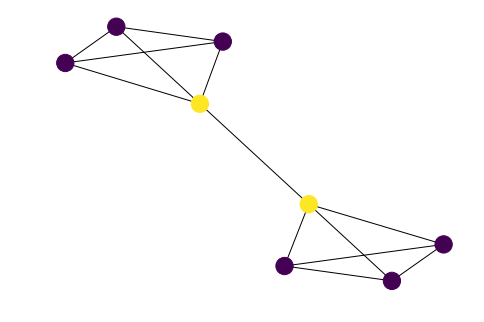

In [23]:
pc
nx.draw_spring(G,node_color=pc,cmap='viridis')


Cartographic analysis generally only works on large networks, since the Z-scoring of module degree requires a relatively large number of values to be computed effectively.  Let's generate a large modular network to see this.  

To generate such a network, we first create each module using the Barabasi-Albert model, and then we connect the modules by preferentially connecting high-degree nodes across modules.



In [24]:
nmods=3
modsize=100
nedges = 20 # for B-A generator
A_full = numpy.zeros((modsize*nmods,modsize*nmods))
partition=numpy.zeros(A_full.shape[0])
for m in range(nmods):
    Gtmp=nx.barabasi_albert_graph(modsize,nedges)
    partition[m*modsize:(m+1)*modsize]=m
    A_full[m*modsize:(m+1)*modsize,m*modsize:(m+1)*modsize]=nx.adjacency_matrix(Gtmp).todense()


If we look at the adjacency matrix so far, we will see that there are no connections between modules, and plotting using spring-embedding shows three disconnected components:

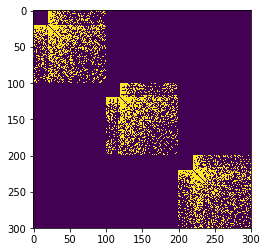

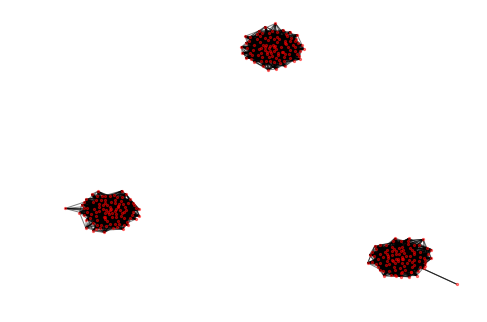

In [25]:
plt.imshow(A_full)
G_mod=nx.from_numpy_array(A_full)
modularity(G_mod,partition)
plt.figure()
nx.draw_spring(G_mod,node_size=5,alpha=.5)

Now let's connect the modules using a second level of preferential attachment - that is, nodes that have higher degree within their own module are also more likely to be connected to another module.  First let's confirm that the degree distribution is indeed long-tailed as we would expect:

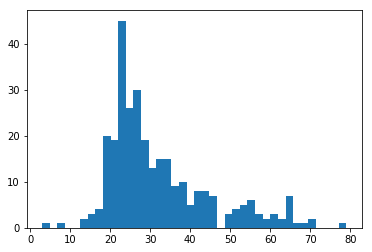

In [26]:
degree = numpy.array([G_mod.degree[i] for i in G_mod.nodes])
_=plt.hist(degree,40)

Now we add edges connecting the high-degree nodes:

In [27]:
edgeidx=numpy.argsort(degree)[::-1]
n_bw_edges=40
p_edge=0.6

# randomly choose some of the high-degree nodes to be connector hubs
connectorhubs=edgeidx[:n_bw_edges][numpy.random.rand(n_bw_edges)<p_edge]

for i in itertools.combinations(connectorhubs,2):
    if not i in G_mod.edges:
            G_mod.add_edge(i[0],i[1])

0.6159276507854057


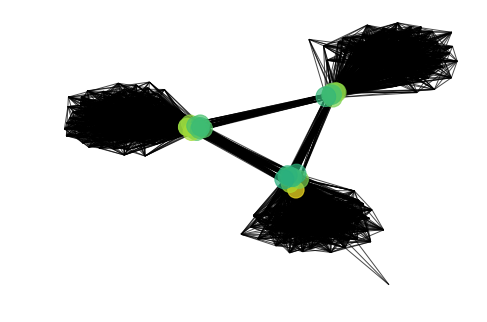

In [28]:
mdzs=module_degree_zscore(G_mod, partition)
pc=participation_coefficient(G_mod, partition)
print(modularity(G_mod,partition))

nx.draw_spring(G_mod,alpha=.7,node_color=mdzs,cmap='viridis',node_size=pc*800)


Now let's create the cartographic profile for the network.

/Users/poldrack/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/poldrack/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


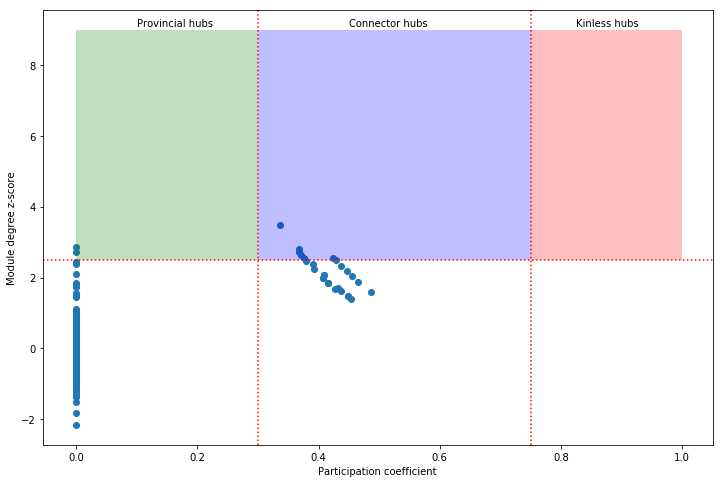

In [29]:
# put everything into a data frame
cartography=pandas.DataFrame(numpy.hstack((pc[:,numpy.newaxis],mdzs[:,numpy.newaxis])),
                             columns=['PC','MDZS'],
                            index=G_mod.nodes)
cartography
plt.figure(figsize=(12,8))
plt.scatter(cartography.PC,cartography.MDZS)
ax=plt.gca()

# print names for certain hubs
for i, txt in enumerate(cartography.index):
    if  cartography.MDZS[i]>4 or (cartography.MDZS[i]>2.5 and cartography.PC[i]>0.75):
        ax.annotate(txt, (cartography.PC[i], cartography.MDZS[i]))
        
# add lines and anntation for Guimera/Amaral regions
plt.axvline(0.75, color='r',linestyle='dotted')
plt.axvline(0.3, color='r',linestyle='dotted')
plt.axhline(2.5, color='r',linestyle='dotted')
plt.xlabel('Participation coefficient')
plt.ylabel('Module degree z-score')
ymax=9
ax.fill_between([0,0.3], [2.5,2.5],[ymax,ymax], facecolor='green', alpha=0.25)
ax.fill_between([0.3,0.75], [2.5,2.5],[ymax,ymax], facecolor='blue', alpha=0.25)
ax.fill_between([0.75,1.], [2.5,2.5],[ymax,ymax], facecolor='red', alpha=0.25)
plt.annotate('Provincial hubs',[0.1,ymax+0.1])
plt.annotate('Connector hubs',[0.45,ymax+0.1])
plt.annotate('Kinless hubs',[0.825,ymax+0.1])

cartography['hubtype']=0
cartography['hubtype'][(cartography.MDZS>2)&(cartography.PC<=0.3)]=1
cartography['hubtype'][(cartography.MDZS>2)&(cartography.PC>0.3)]=2


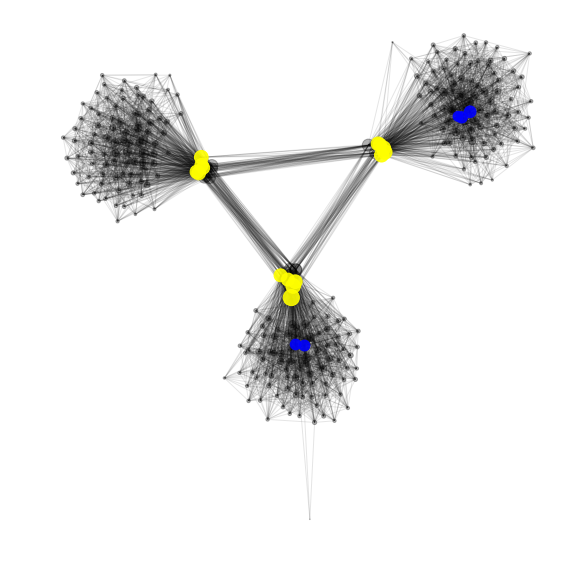

In [30]:
plt.figure(figsize=(8,8))
pl=nx.spring_layout(G_mod)
nodelists={}
nx.draw_networkx_edges(G_mod,pos=pl,alpha=0.1)
colors=['black','blue','yellow']
alphas=[0.3,0.9,0.9]
for t in range(3):
    nodelists[t]=[i for i in range(cartography.shape[0]) if cartography['hubtype'][i]==t]

    nx.draw_networkx_nodes(G_mod,pos=pl,node_size=[(G_mod.degree(i)/6)**2 for i in nodelists[t]],
                       nodelist=nodelists[t],
                       node_color=colors[t],alpha=alphas[t])

plt.axis('off')
plt.tight_layout()


### Rich clubs

In many real-world networks (including brains) there is a subset of high-degree nodes that are preferentially connected to one another as well, which is referred to as a *rich club* ([van den Heuvel & Sporns, 2011](http://www.jneurosci.org/content/31/44/15775)).  The presence of a rich club can be quantified using the rich club coefficent $\phi$, which is computed as follows:

$$
\phi(k) = \frac{2E_{>k}}{N_{>k}(N_{>k} - 1)}
$$

This is the ratio of edges between nodes with degree greater than k to the number of possible edges between those nodes.  In general we want normalize this by comparing the observed value to what one expects on the basis of a matched random network (null model):

$$
\phi_{norm}(k) = \frac{\phi(k)}{\phi_{random}(k)}
$$

We compute this for each level of k and then examine the distribution to see whether it exceeds one.  In order to assess the variability across multiple instantiations of the null model, we run it repeatedly to see the distribution of rcc values (this will take a few minutes):

In [31]:
def get_rcc(G,maxtries=10):

    good_rcc=False
    tries=0
    while not good_rcc:
        try:
            rcc=nx.rich_club_coefficient(G_mod,normalized=True,Q=10)
            good_rcc=True
        except ZeroDivisionError:
            tries+=1
        if tries>=maxtries:
            Exception('Too many tries!')
    # return a vector rather than a dict
    idx=numpy.sort(list(rcc.keys()))
    
    return(numpy.array([rcc[i] for i in idx]))

nsims=100
rccdata=numpy.zeros((max(degree),nsims))*numpy.nan
for s in range(nsims):
    tmp=get_rcc(G_mod)
    rccdata[:max(degree),s]=tmp[:max(degree)]



Minimum degree with all RCC> 1.25: 46
Density: 0.13333333333333333


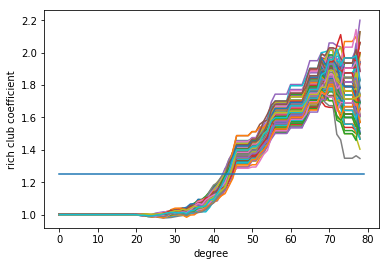

In [32]:
minrcc=numpy.min(rccdata,1)
p=plt.plot(rccdata)
plt.xlabel('degree')
plt.ylabel('rich club coefficient')
rcc_thresh=1.25
plt.plot([0,max(degree)],[rcc_thresh,rcc_thresh])
mindegree=numpy.where(minrcc>rcc_thresh)[0][0]
print('Minimum degree with all RCC> %s:'%rcc_thresh,mindegree)
print('Density:',numpy.mean(degree>mindegree))

Plotting the RCC values across simulations shows that the RCC starts to be consistently above 1 around a degree of 40, and exceeds our arbitrary threshold of 1.25 for degrees greater than 59.  Let's visualize the network highlighting those vertices:

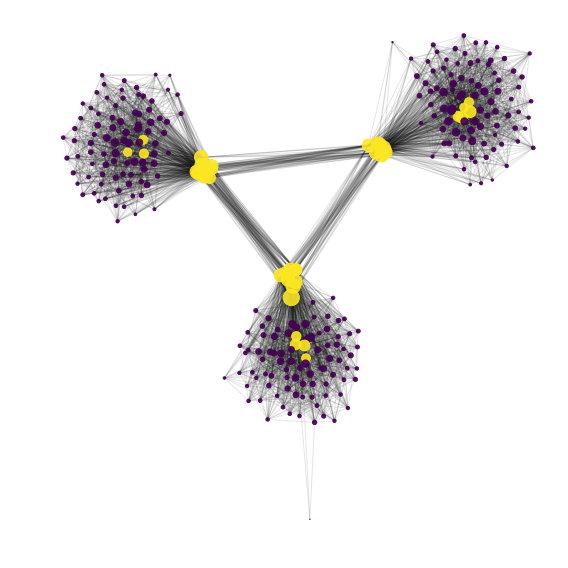

In [33]:
plt.figure(figsize=(8,8))
nx.draw_networkx_edges(G_mod,pos=pl,alpha=0.1)

nx.draw_networkx_nodes(G_mod,pos=pl,node_size=[(G_mod.degree(i)/6)**2 for i in G_mod.nodes],
                       node_color=(degree>mindegree),alpha=0.9)

plt.axis('off')
plt.tight_layout()
